# Chapter 37. Long-Short Equity Strategies

이것은 일종의 industry standard 한 전략이다.

Long-short equity strategy 는 시장의 모든 주식을 어떤 모델을 이용하여 rank 하고, top n 개(top basekt, high return assets)는 long, bottom n 개(bottom basekt, low return assets)는 short 한다. 이 때 long 과 short 의 dollar volume 은 동일하게 한다. 주식 종목들의 ranking 을 매기고, 단지 몇개의 risky bet 대신  많은 bet 를 통해 수백, 수천개 position 을 만들면 통계학적으로 굳건하게 된다. 같은 dollar volume 의 long 과 short position 이 market neutral (market 움직임에 영향 없음) 하도록 하므로 순수하게 ranking scheme 의 quality 에 betting 하는 것이다. 

## Ranking Scheme

ranking scheme 은 개별 stock 에 number 를 부여하는 특정 모델이다. 숫자가 높을 수록 좋거나 나쁘다. 예를 들어 value factor, technical factor, pricing model 또는 이 모든 것의 조합이다. Ranking 부여 scheme 은 long-short equity strategy 의 비결이다. 따라서, 그 것을 개발하는 것은 사소한 문제가 아니다.

## Making a Bet on the Ranking Scheme

Ranking scheme 은 일단 만들어지면, 이익을 취할 수 있다. 같은 금액 (dollar neutral) 을 투자하여 top ranking 을 사고 bottom 을 판다. market neutral 하므로 ranking 의 quality 에 비례하여 돈을 벌게 된다.

### Long and Short Baskets

m 개의 주식에 ranking 을 매기고, d 달러의 투자금이 있으며, 유지할 총 목표 position 숫자가 2n 개이다. long and short basket 이 다음과 같이 구성 되었다. 

ranking 상의 1 .... n 달러 자리 마다 $\frac{1}{2n} * d$ 달러의 주식을 sell 하고, ranking 상의 m-n ... m 자리의 주식에 $\frac{1}{2n} * d$ 달러의 주식을 buy 한다.


#### Friction Because of Prices 

주식의 가격이 언제나  $\frac{1}{2n} * d$ 로 균등히 나누어지지 않지만, 주식들은 integer 금액으로 사야하므로 언제나 정확히 떨어지지는 않고 알고리즘에서 근사치에 가깝게 해야한다. 대부분 알고리즘은 수행중에 어느정도의 leverage 에 접근하므로, 주식당 $\frac{1}{2n} * d$ 달러보다 약간 더 사는 것은 무방하지만, 투자금이 적을 때는 문제가 발생한다. 예를 들어 전체 투자금이 $d = 100000$ 이고 $n = 500$ 인 경우,

$$\frac{1}{2n} * d = \frac{1}{1000} * 100000 = 100$$

가 되는데, 이 것은 비싼 주식의 경우(ex. 주시 종목당 100 달러씩 사야하나 100 불보다 비싼 주식) 큰 문제가 되고 algorithm 이 초과 leverage (주당 60 불 x 2 = 120 불 매입) 를 일으키게 한다. 이 것은 더 적은 숫자의 주식을 매매하거나 투자금을 증가시켜 완화할 수 있다. 다행히도, 이 문제는 long-short equity strategy 가 매우 높은 capacity 인 경우가 대부분이고 투자 가능 금액의 ceiling 이 없으므로 완화될 수 있다. 

### Returns Come From The Ranking Spread

long-short equity strategy 로부터의 수익은 얼마나 ranking 이 high 와 low return 으로 잘 spread 되었는가에 달려 있다. 다음 예가 이를 보여준다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)           # 실제 ranking system 에서는 각 factor 에 score  부여하여 산출
equity_names = ['Equity ' + str(x) for x in range(10000)]                      # 10000 개의 주식
# Put it into a dataframe
factor_data = pd.Series(current_factor_values, index = equity_names)   
factor_data = pd.DataFrame(factor_data, columns=['Factor Value'])       # 10000 개 주식의 factor 값
# Take a look at the dataframe
factor_data.head()

,Factor Value
Equity 0,-0.386646
Equity 1,0.462341
Equity 2,0.659714
Equity 3,-0.178685
Equity 4,1.409589


In [29]:
# 미래의 return(ex. 내일 or 30 일 후 예상 return) 이 현재의 factor value 에 종속된다고 가정 (current factor value + noise)
# future_returns 는 current_factor_values 와 매우 correlated 되어 있다.

future_returns = current_factor_values + np.random.normal(0, 1, 10000)     #  noise 추가 

returns_data = pd.Series(future_returns, index=equity_names)
returns_data = pd.DataFrame(returns_data, columns=['Returns'])
# Put both the factor values and returns into one dataframe
data = returns_data.join(factor_data)
# Take a look
data.head(10)

,Returns,Factor Value
Equity 0,-1.073833,-0.386646
Equity 1,2.084946,0.462341
Equity 2,1.847166,0.659714
Equity 3,-1.085229,-0.178685
Equity 4,0.069336,1.409589
Equity 5,-0.434155,-0.691031
Equity 6,1.447802,-0.151000
Equity 7,1.881368,1.074369
Equity 8,0.932230,0.226414
Equity 9,-1.537795,-0.142512


factor value 와 return 을 구했으므로, factor value 에 따라 주식에 ranking 을 메겨 long-short position 을 구사할 때 어떻게 되는지 살펴보자.

아래그림은 long_short equity strategy 의 trade-mark 같은 plot 이다. basket 의 ranking 이 올라가면 mean return 이 증가.

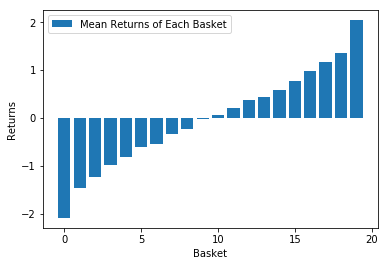

In [42]:
# Rank the equities : Factor Value 에 따라 data 정렬
ranked_data = data.sort_values('Factor Value')

# Compute the returns of each basket  
# Baskets of size 500, so we create an empty array of shape (10000/500)  : 500 개 단위의 20 개 basket 으로 정렬한 주식 분류

number_of_baskets = int(10000/500)
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()        # basket 별 평균 return

# Plot the returns of each basket
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Mean Returns of Each Basket']);
plt.xticks(np.arange(0, 21, step=5));

top basket 을 long 하고 bottom basket 을 short 할 때의 return 계산 : 

basket[19] - bakset[0] = +2% - (-2%)

In [26]:
basket_returns[number_of_baskets-1] - basket_returns[0]

4.1050662600020029

### Market Neutrality is Built-In

ranking 의 spread 에 기초하여 돈 버는 것은 market 변화의 영향을 받지 않는다. 

동일한 금액만큼을 basket 에 long-short 했으므로 이미 market risk 가 반영되어 market neutrality 되어 있는 상태임. 이 것을 확인하기 위해 시장의 모든 주식들이 -10 만큼의 market risk 를 받는다고 가정하고 다시 rebalance 하여 동일한 long-short equity 를 하면 역시 같은 4% 수익을 얻음.

In [46]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)
equity_names = ['Equity ' + str(x) for x in range(10000)]

# Put it into a dataframe
factor_data = pd.Series(current_factor_values, index = equity_names)
factor_data = pd.DataFrame(factor_data, columns=['Factor Value'])

# Now let's say our future returns are dependent on our factor values
future_returns = -10 + current_factor_values + np.random.normal(0, 1, 10000)

returns_data = pd.Series(future_returns, index=equity_names)
returns_data = pd.DataFrame(returns_data, columns=['Returns'])

# Put both the factor values and returns into one dataframe
data = returns_data.join(factor_data)

# Rank the equities
ranked_data = data.sort_values('Factor Value')

# Compute the returns of each basket
# Baskets of size 500, so we create an empty array of shape (10000/500)

number_of_baskets = int(10000/500)
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

basket_returns[number_of_baskets-1] - basket_returns[0]

4.1179398295251008

## Choice and Evaluation of a Ranking Scheme

ranking scheme 은 우위를 점할 수 있는, long-short equity strategy 의 가장 중요한 component 이다. Good ranking system 을 고르는 것이 know-how 이고 쉽지 않다. 우선 현재 알려진 기술을 파악하고 수정하여 return 을 증가시킬 수 있는 모델을 개발한다.

ranking scheme 조사에서 ranking system 이 실제로 future return 에 predictive 한지 여부를 정하는 것이 중요한데 spearman rank correlation 으로 할 수 있다.

## Long-Short is a Modular Strategy

long-short equity 의 좋은 점은 모듈화 되어 있어서 어떠한 ranking scheme 이라도 끼워 넣을 수 있다는 것이다. 이후 과정은 기계적이다. 일단 하나의 long-short strategy 를 갖게 되면, ranking scheme 만 다른 ranking scheme 으로 바꾸어 넣을 수 있고 나머지는 그냥 사용하면 된다. 따라서 매번 code 를 수정할 필요 없이 idea 를 빠르게 반복할 수 있어 편리하다.

ranking scheme 은 어떤 model 에서도 가져올 수 있다. 반드시 value based factor model 일 필요는 없고, 1 개월 앞서서 return 을 예측고 그에 따라 ranking 을 부여하는 machine learning 기술일 수도 있다. 또는 pricing model 에 의해 저평가주식을 사고 고평가 주식을 파는 것일 수도 있다 (buy low, sell high)

하나의 주식 가격은 정확히 예측하기 힘들지만 55 ~ 60 % 가능하다면 5~10 % 의 우위를 casino 에서 가지고 있는 것과 같고, 이러한 우위는 주식 수가 작으면 volatility 가 워낙 커서 큰 의미 없을 수 있으나, casino 의 one table 에 모든 betting 을 하는 대신 작은 금액을 많은 table 에 betting 하면 consistent 한 5% 의 승리를 지속적으로 얻는 것과 같은 원리이다. 이 것이 long-short equity strategy 가 지향하는 것이다.

따라서, 개별 주식의 미래 가격은 정확히 예측하기 어려우나 5% 정도의 edge 를 수백, 수천개 position 을 보유하는 것으로 전체 trend 를 장악하고 지속적으로 평균 수익을 내는 것이 long-short equity strategy 의 idea 이다.

## Additional Considerations

### Rebalancing Frequency --> 매우 중요

모든 ranking system 은 timeframe 이 조금씩 바뀜에 따라 return 예측을 잘하고 못하고가 달라진다. price-based mean version 은 향후 몇일에 대해서 predictive 하고, value-based factor model 은 향후 수개월에 대해 predictive 하다. 적용하려는 model 이 predictive 한 timeframe 을 정하고 실제 전략 수행 이전에 통계적으로 검증하는 것이 중요하다. 

long-short strategy 를 너무 자주 trade 하는 것은 거래비용을 증가시키는 위험성이 있다.  1000 개의 position 을 50% 만 rebalance 하여도 500 개의 sell 과 500 개의 buy 가 발생하므로 1000 개의 거래 비용이 발생한다.

You do want to overfit by trying to optimize the relabancing frequency, you will inevitably find one that is randomly better than others, but not necessary because of anything in your model.

일단 ranking scheme 이 predictive 할 수 있는 timeframe 을 정했으면 model 의 잇점을 최대한 살릴 수 있도록 frequency 에 맞추어 rebalancing 을 하도록 한다.

### Capital Capacity

모든 strategy 는 trade 하여 profitable 할 수 있는 최소 및 최대 금액이 있다. 

### Number of Equities Traded

#### Transaction Costs

Trading many equities will result in high transaction costs. Say that you want to purchase $1000$ equities, you will incur thousands of dollars of costs per rebalance. Your capital base must be high enough that the transaction costs are a small percentage of the returns being generated by your strategy. Say that you are running $100,000$ dollars and making $1\%$ per month, then the $1000$ dollars of transaction fees per month would take up your all of returns. You would need to be running the strategy on millions of dollars for it to be profitable over $1000$ equities.

The minimum capacity is quite high as such, and dependent largely on the number of equities traded. However, the maximum capacity is also incredibly high, with long-short equity strategies capable of trading hundreds of millions of dollars without losing their edge. This is true because the strategy rebalances relatively infrequently, and the total dollar volume is divided by the number of equities traded. So if you turn over your entire portfolio of $100,000,000$ every month while running 1000 equities, you are only running $100,000$ dollar-volume per month through each equity, which isn't enough to be a significant market share for most securities.